In [1]:
import os, sys
# for accessing src, stan, etc.
sys.path.append(os.path.abspath(os.path.join("../..")))

import bayesflow as bf
import numpy as np
from src.AmortizedMixture import *
from src.models.NormalHmm import *

from cmdstanpy import CmdStanModel
from model import model

import matplotlib.pyplot as plt


/Users/simonkucharsky/projects/bayesflow/amortized-mixture/.venv/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
filtering_posterior = bf.trainers.Trainer(
    amortizer = AmortizedMixturePosterior(
        amortized_mixture = AmortizedMixture(
            inference_net = DependentClassificator(num_outputs=model.n_cls, bidirectional=False)
        ),
        amortized_posterior = AmortizedPosterior(
            inference_net = bf.networks.InvertibleNetwork(num_params=model.n_par, num_coupling_layers=10, coupling_design="spline"),
            summary_net = bf.networks.SequenceNetwork(summary_dim=model.n_par*3, num_conv_layers=4, bidirectional=True),
            summary_loss_fun = "MMD"
        )  
    ),
    generative_model = model,
    checkpoint_path = "checkpoints/filtering_posterior",
    configurator = lambda x: x
)

INFO:root:Loaded loss history from checkpoints/filtering_posterior/history_150.pkl.
INFO:root:Networks loaded from checkpoints/filtering_posterior/ckpt-150
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [3]:
stan_model = CmdStanModel(stan_file=os.path.join('..', '..', 'stan', 'normal-hmm.stan'))

DEBUG:cmdstanpy:found newer exe file, not recompiling


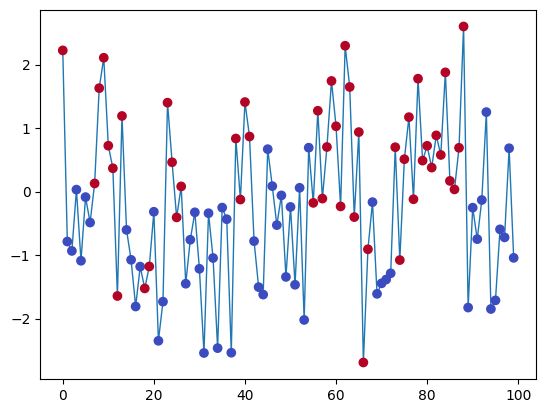

In [4]:
parameters = {
    "p": [np.array([0.8, 0.2]), np.array([0.15, 0.85])],
    "mu": np.array([-1.0, 0.8])
}
context = {
    "n_obs": 100
}
latents, observables = model._simulator(
    parameters=parameters, 
    context=context).values()

plt.plot(observables, linewidth=1, zorder=-1)
plt.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')

In [5]:
bf_data = model.config_bayesflow(context, observables)

In [6]:
posterior, filtering = filtering_posterior.amortizer.sample(bf_data, n_samples=4000)

In [7]:
filtering = filtering[0,:,:,1]
posterior = posterior[0,:,:]

In [8]:
stan_data = {
    'n_obs': context['n_obs'],
    'n_cls': model.n_cls,
    'y': observables,
    'separation': model.separation,
    'alpha': model.alpha
}

In [9]:
stan_fit = stan_model.sample(stan_data, adapt_delta=0.95)

DEBUG:cmdstanpy:cmd: /Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/normal-hmm info
cwd: None
DEBUG:cmdstanpy:input tempfile: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/0nvua8l3.json
15:53:51 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:CmdStan args: ['/Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/normal-hmm', 'id=1', 'random', 'seed=44488', 'data', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/0nvua8l3.json', 'output', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:idx 3
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:running CmdStan, nu


15:53:53 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/Users/simonkucharsky/projects/bayesflow/amortized-mixture/stan/normal-hmm', 'id=1', 'random', 'seed=44488', 'data', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/0nvua8l3.json', 'output', 'file=/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1', 'delta=0.95']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_1.csv
 console_msgs (if any):
	/var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  samp

In [10]:
print(stan_fit.diagnose())

DEBUG:cmdstanpy:cmd: /Users/simonkucharsky/.cmdstan/cmdstan-2.34.1/bin/diagnose /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_1.csv /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_2.csv /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_3.csv /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_4.csv
cwd: None


Processing csv files: /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_1.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_2.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_3.csv, /var/folders/vn/tvq3_rgx63795x08zmwtn_rr0000gn/T/tmpa7_ciuey/normal-hmmg65ep285/normal-hmm-20240621155351_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [11]:
stan_filtering = stan_fit.draws_pd(vars=['filtering'])
stan_filtering = stan_filtering.iloc[:, stan_data['n_obs']:]
stan_filtering = np.array(stan_filtering)

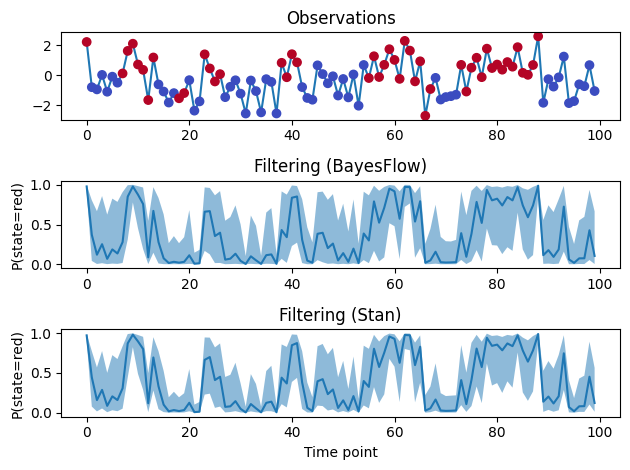

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.plot(range(len(observables)), observables, zorder=-1)
ax1.scatter(range(len(observables)), observables, c=latents, cmap='coolwarm')
ax1.set_title("Observations")

ax2.plot(range(len(observables)), np.median(filtering, axis=0))
ax2.fill_between(
    range(len(observables)),
    np.quantile(filtering, q=0.01, axis=0),
    np.quantile(filtering, q=0.99, axis=0),
    alpha=0.5
)
ax2.set_title("Filtering (BayesFlow)")
ax2.set_ylabel("P(state=red)")

ax3.plot(range(len(observables)), np.median(stan_filtering, axis=0))
ax3.fill_between(
    range(len(observables)),
    np.quantile(stan_filtering, q=0.01, axis=0),
    np.quantile(stan_filtering, q=0.99, axis=0),
    alpha=0.5
)
ax3.set_title("Filtering (Stan)")
ax3.set_ylabel("P(state=red)")
ax3.set_xlabel("Time point")
fig.tight_layout()

## Compare posterior distributions

In [13]:
p, mu = model.extract_pars(posterior).values()

In [14]:
stan_p = stan_fit.draws_pd(vars = ["transition_matrix"])
stan_p = np.array(stan_p)
stan_p = np.reshape(stan_p, (stan_p.shape[0], model.n_cls, model.n_cls))
stan_p = np.swapaxes(stan_p, 1, 2)

stan_mu = stan_fit.draws_pd(vars = ["mu"])
stan_mu = np.array(stan_mu)

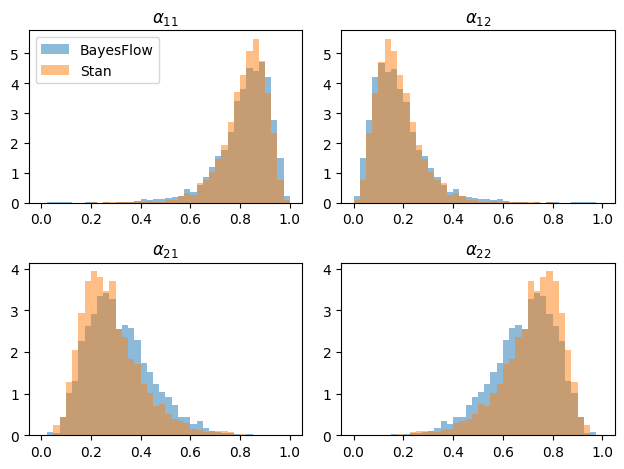

In [15]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.set_title(r'$\alpha_{11}$')
ax2.set_title(r'$\alpha_{12}$')
ax3.set_title(r'$\alpha_{21}$')
ax4.set_title(r'$\alpha_{22}$')

ax1.hist(p[:,0,0], bins=np.linspace(0, 1, 41), alpha=0.5, density=True, label="BayesFlow")
ax2.hist(p[:,0,1], bins=np.linspace(0, 1, 41), alpha=0.5, density=True)
ax3.hist(p[:,1,0], bins=np.linspace(0, 1, 41), alpha=0.5, density=True)
ax4.hist(p[:,1,1], bins=np.linspace(0, 1, 41), alpha=0.5, density=True)

ax1.hist(stan_p[:,0,0], bins=np.linspace(0, 1, 41), alpha=0.5, density=True, label="Stan")
ax2.hist(stan_p[:,0,1], bins=np.linspace(0, 1, 41), alpha=0.5, density=True)
ax3.hist(stan_p[:,1,0], bins=np.linspace(0, 1, 41), alpha=0.5, density=True)
ax4.hist(stan_p[:,1,1], bins=np.linspace(0, 1, 41), alpha=0.5, density=True)


ax1.legend()

fig.tight_layout()

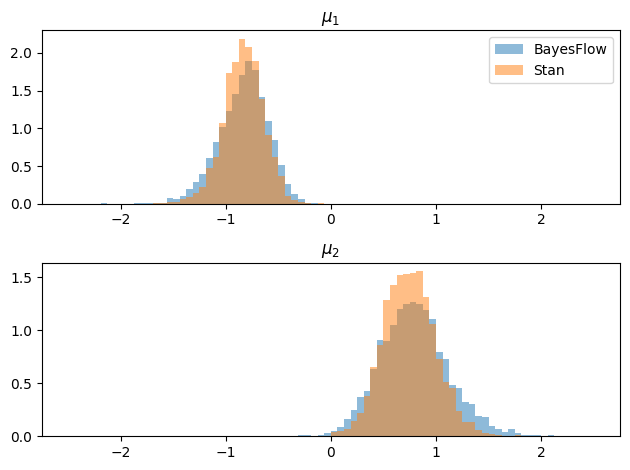

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_title(r"$\mu_1$")
ax2.set_title(r"$\mu_2$")

ax1.hist(mu[:,0], bins = np.linspace(-2.5, 2.5, 81), alpha=0.5, density=True, label = "BayesFlow")
ax2.hist(mu[:,1], bins = np.linspace(-2.5, 2.5, 81), alpha=0.5, density=True)


ax1.hist(stan_mu[:,0], bins = np.linspace(-2.5, 2.5, 81), alpha=0.5, density=True, label = "Stan")
ax2.hist(stan_mu[:,1], bins = np.linspace(-2.5, 2.5, 81), alpha=0.5, density=True)

ax1.legend()

fig.tight_layout()